<a href="https://colab.research.google.com/github/Himagination/TensorFlow_Developer/blob/main/05_Transfer_Learning_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Fine-Tuning transfer learning with TensorFlow

In [ ]:
!nvidia-smi

Tue Jan 18 14:26:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however this is tedious.

So, it's a good idea to put functions you'll want to use again in a script and download and import your notebooks. 

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-01-18 20:18:16--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-18 20:18:16 (109 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# import helper functions we're going to use in the notebook

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem(recognizing images of food)

In [ ]:
# get 10% of training data of 10 classes of food
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-01-18 16:36:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 2607:f8b0:4023:c0b::80
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  82.8MB/s    in 1.9s    

2022-01-18 16:36:51 (82.8 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Check out how many images abd subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [ ]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir, 
                                                                            image_size=IMG_SIZE, 
                                                                            label_mode='categorical', 
                                                                            batch_size=32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir, 
                                                                image_size=IMG_SIZE, 
                                                                label_mode='categorical', 
                                                                batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Check out the class name of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.48724489e+01 1.48724489e+01 4.87244892e+00]
   [1.30714283e+01 1.30714283e+01 3.07142854e+00]
   [1.40000000e+01 1.55714283e+01 4.78571415e+00]
   ...
   [1.20663147e+01 1.72806091e+01 1.17091980e+01]
   [6.29072809e+00 1.32856445e+01 8.95400524e+00]
   [1.33417645e+01 2.36274700e+01 1.79846172e+01]]

  [[1.43775501e+01 1.43775501e+01 4.37755108e+00]
   [1.40000000e+01 1.60000000e+01 5.00000000e+00]
   [1.57142859e+01 1.77142868e+01 6.71428585e+00]
   ...
   [7.98468399e+00 1.31989784e+01 7.62756729e+00]
   [6.14794016e+00 1.21479406e+01 8.14794064e+00]
   [1.68111382e+01 2.58111382e+01 2.08111382e+01]]

  [[1.63571434e+01 1.67857151e+01 6.57142878e+00]
   [1.72142868e+01 1.92142868e+01 8.21428585e+00]
   [1.60918350e+01 1.82602043e+01 7.59693909e+00]
   ...
   [6.21427727e+00 1.14285717e+01 5.85716057e+00]
   [4.30099916e+00 1.03009996e+01 6.30099916e+00]
   [1.68570557e+01 2.58570557e+01 2.08570557e+01]]

  ...

  [[1.19928551e+02 1.40142807e+02 8.11428146e+01]
   [1

# Introduction to Keras Functional API to build models

Keras Sequential vs Functional API

* Similarities: compiling, fitting, evaluating
* Differences: Model Construction(The **Functional API is more flexible** and able to produce more sophisticated models.)

## Model 0: Building a transfer learning model using the Keras Functional API

The Sequential API is straight-forward, it runs our layers in Sequential order.

But the Functional API gives us more flexibility.

In [ ]:
# 1. Create a base model  with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')

# 4. If using model like ResNet50V2 you will need to normalize input
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. Pass the Inputs  to base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy', 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=['accuracy'])

# 10. Fit the model
model_0_history = model_0.fit(train_data_10_percent, 
                              epochs=5, 
                              steps_per_epoch=len(train_data_10_percent), 
                              validation_data=test_data, 
                              validation_steps=int(0.25*len(test_data)), 
                              callbacks=[create_tensorboard_callback(dir_name='transfer_learning', 
                                                                     experiment_name='10_percent_feature_extraction')])

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220118-174245
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


24/24 [==============================] - 79s 3s/step - loss: 1.8665 - accuracy: 0.4093 - val_loss: 1.3235 - val_accuracy: 0.7105
Epoch 2/5
24/24 [==============================] - 72s 3s/step - loss: 1.1274 - accuracy: 0.7373 - val_loss: 0.9331 - val_accuracy: 0.7747
Epoch 3/5
24/24 [==============================] - 56s 2s/step - loss: 0.8326 - accuracy: 0.8187 - val_loss: 0.7448 - val_accuracy: 0.8043
Epoch 4/5
24/24 [==============================] - 72s 3s/step - loss: 0.6983 - accuracy: 0.8267 - val_loss: 0.6615 - val_accuracy: 0.8322
Epoch 5/5
24/24 [==============================] - 72s 3s/step - loss: 0.5910 - accuracy: 0.8573 - val_loss: 0.6193 - val_accuracy: 0.8306


In [ ]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 103s 1s/step - loss: 0.6074 - accuracy: 0.8384


[0.6074015498161316, 0.8384000062942505]

In [ ]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [ ]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


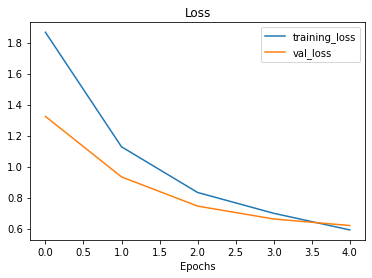

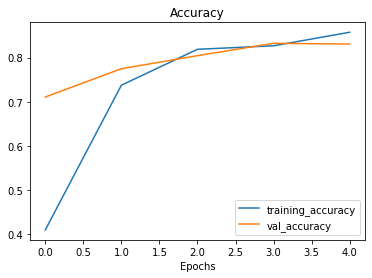

In [ ]:
# Check out model's training curves
plot_loss_curves(model_0_history)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280)

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.


In [ ]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]



In [ ]:
# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}")

2D global average pooled random tensor:
 [[-0.09368646 -0.45840445 -0.28855976]]


In [ ]:
# Check the shape
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [ ]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

**Note:** One of the reasons feature extraction transfer learning is named how it is because what often happens is pretrained model outputs a **Feature Vector** (a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of the tf.keras.layers.GlobalAveragePooling2D() layer) which can then be used to extract patterns out of our own specific problem.

A **Feature Vector** is a learned representation of the input data(a compressed form of the input data based on how the model sees it)

# Running a series of experiments on our Food Vision data

We have seen the incredible results transfer learning canget with only 10% of the training data, but how does it go with 1% of the training data... how about we set a bunch of experiments to find out:

1. `model_1` - Use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - Use feature extraction transfer learning with 10% of the training with data augmentation.
3. `model_3` - Use fine-tuning transfer learning on 10% of the training data with data augmentation.

**Note:** Throughout all experiments the same test dataset will be used to evaluate our model...this ensures consistency across evaluation metrics.

## Getting and Preprocessing Data

In [3]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

# Unzip
unzip_data("10_food_classes_1_percent.zip")

--2022-01-18 20:18:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.107.128, 173.194.216.128, 64.233.170.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.107.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   202MB/s    in 0.6s    

2022-01-18 20:18:41 (202 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [4]:
# Create training and test dir
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [5]:
# How many images we are working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There a

In [6]:
import tensorflow as tf
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent, 
                                                                           image_size=IMG_SIZE, 
                                                                           label_mode='categorical', 
                                                                           batch_size=32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, 
                                                                label_mode='categorical', 
                                                                image_size=IMG_SIZE, 
                                                                batch_size=32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

Using data augmentation inside the model have following benefits:

* Preprocessing of images happens on the GPU rather than the CPU.
* Image data augmentation only happens during training, so we can still export our model and use it elsewhere.

In [7]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc.
data_augmentation = keras.Sequential([
                                      preprocessing.RandomFlip('horizontal'), 
                                      preprocessing.RandomRotation(0.2), 
                                      preprocessing.RandomZoom(0.2), 
                                      preprocessing.RandomWidth(0.2), 
                                      preprocessing.Rescaling(1/255.)], name='data_augmentation')


### Visualize our data augmentation layer

(-0.5, 436.5, 511.5, -0.5)

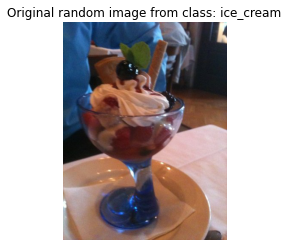

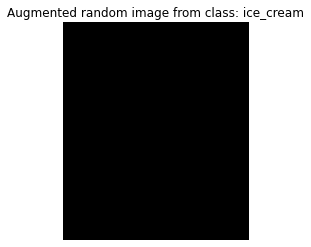

In [15]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

# Now let's plot our data augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)

# Using a small dataset to experiment faster( e.g. 10% of training samples)

# Data Augmentation(Making your training set more diverse without adding samples)

# Introduce the ModelCheckpoint Callback to save intermediate results.